In [2]:
####################################################################
#IMPORT LIBRARY STATEMENTS 
####################################################################
#Compute libraries
from scipy.ndimage.filters import gaussian_filter1d
from scipy.special import erf, erfinv
from scipy.optimize import root
from scipy.stats import norm, beta
import os
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import zipfile
from fair_scm import *
import datetime
import h5py
import copy
import sys
import deepdish as dd
import numpy as np
from pandas import DataFrame
from statsmodels.api import OLS
import statsmodels.tools.tools

In [3]:
def plot_ts_base(ax,p_dat,nearterm_ref=False):
    
    obs_keys = p_dat['Obs'].keys()
    
    if nearterm_ref==True:
        p_max = p_dat['Obs']['Temp-max'][:] - np.mean(p_dat['Obs']['Temp-max'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_min = p_dat['Obs']['Temp-min'][:] - np.mean(p_dat['Obs']['Temp-min'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:] - np.mean(p_dat['Obs']['Temp-mean-AWI'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
    
    else:
        p_max = p_dat['Obs']['Temp-max'][:]
        p_min = p_dat['Obs']['Temp-min'][:]
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:]
        
    
    #Ascthetic settings
    awi_col = cols['orange']
    gwi_col = cols['vermillion']
    obs_labs = obs_keys
    obs_cols =  ['yellow','green','black','darkred','teal']
        

    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],p_max,p_min,color='grey',alpha=0.5,zorder=2)
    plt.plot(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean),color=cols['vermillion'],linestyle='-',linewidth=1.75,zorder=2)
    
    #Add uncertainty bar on final point for AWI series
    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean)*(1.2),np.array(p_mean)*(0.8),
    color=cols['vermillion'],zorder=5,alpha=0.45,linewidth=0)
    
    
    if nearterm_ref == True:
        plt.axhline(y=1.5-0.87,linewidth=1.5,linestyle='-',color='grey')
        plt.axhline(y=0-0.87,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        #plt.text(x=1960, y=0.7-0.87, s='Human-induced\nwarming', fontsize=13,color=awi_col)
    else:
        plt.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
        #plt.axhline(y=0,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        #plt.text(x=1960, y=0.7, s='Human-induced\nwarming', fontsize=13,color=awi_col)
        
    
    
    warm_end = np.mean(np.array(p_mean)[np.logical_and(np.array(p_dat['Obs']['HadCRUT4']['Years'])>=2017,
    np.array(p_dat['Obs']['HadCRUT4']['Years'])<2018)])
    
    
    
    #plt.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
    plt.scatter(2017.5,warm_end,s=30,color=awi_col,zorder=20)
    
    #Add projection for current warming rate 
    proj_years = np.arange(2018,2100)
    warm_rate = 0.021
    plt.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10)
    
    if nearterm_ref==True:
        plt.plot([2017.5,2017.5],[0-0.87,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
        plt.text(2000,1.81-0.87,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0-0.87,2.0-0.87)
        plt.xlim(1950,2100) 
    
        plt.text(1992,0.15-0.87,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2019,0.93-0.87,'2017',fontsize=8,color=awi_col)
        
    else:
        plt.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
        plt.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
        #plt.text(2000,1.81,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0,2.0)
        plt.xlim(1950,2100) 
    
        #plt.text(1992,0.15,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2015,0.43,'2017',fontsize=10,color='black')
        

    return

In [4]:
def plot_lin_co2dec(te,ax,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4] 
        
        

    #ax.fill_between(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],alpha=0.3,linewidth=0)
    #ax.fill_between(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,color=cols['bluishgreen'],alpha=0.8,linewidth=0)
    ax.fill_between(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],alpha=0.25,linewidth=0)
    ax.fill_between(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],alpha=0.4,linewidth=0)
    
    if nearterm_ref == True:
        ax.text(2040,0.44-0.87,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        ax.set_ylabel(r'Warming relative to 2006-2015 ($^{\circ}$C)',fontsize=12)
    else:
        #ax.text(2040,0.44,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        ax.set_ylabel(r'Warming relative to 1850-1900 ($^{\circ}$C)',fontsize=12)
        
    
    #plt.grid()
    ax.set_axisbelow(True)

    
    return

In [5]:
def stu_plot_temppanel(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] - np.mean(lb['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4] - np.mean(lb['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3] - np.mean(lb['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0] - np.mean(lb['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] 
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3]
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0]
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4]

    
    ax.plot(lb['years'][lb['years'][:]>2017],plot_lu_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=2,alpha=1)
    ax.plot(lb['years'][lb['years'][:]>2017],plot_ul_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=2,alpha=1)
    ax.plot(lb['years'][lb['years'][:]>2017],plot_ll_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=1.2,alpha=0.65)
    ax.plot(lb['years'][lb['years'][:]>2017],plot_uu_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=1.2,alpha=0.65)
    
    
    
    return

In [6]:
def stu_plot_temppanel_alt(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] - np.mean(te['temp_zero']['RCP8.5'][1][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4] - np.mean(te['temp_zero']['RCP8.5'][1][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3] - np.mean(te['temp_zero']['RCP8.5'][1][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0] - np.mean(te['temp_zero']['RCP8.5'][1][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] 
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3]
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0]
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4]
    
    
    ax.plot(te['years'][te['years'][:]>2017],plot_lu_a[te['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=2,alpha=1)
    ax.plot(te['years'][te['years'][:]>2017],plot_ul_a[te['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=2,alpha=1)
    ax.plot(te['years'][te['years'][:]>2017],plot_ll_a[te['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=1.2,alpha=0.65)
    ax.plot(te['years'][te['years'][:]>2017],plot_uu_a[te['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=1.2,alpha=0.65)
    
    
    
    return

In [7]:
def plot_emissionspanel_an(ax1,te,lb,gcp_data,gcp_ems):
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=2, alpha = 0.45)
    ax1.plot(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_blue'],linewidth=2)
    ax1.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['pale_blue'],linewidth=0)
    ax1.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
    44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=0,alpha=0.15)
    
    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['line_grey'],linewidth=2)
    ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['pale_blue'],linewidth=0)
    
    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    ax1.set_ylim(0,55)
    ax1.set_ylabel('GtCO$_{2}$/yr',fontsize=10)
    
    ax1.text(0.97,1.0,'Annual CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')

    
    
    return

In [8]:
def plot_cumemissionspanel(ax1,te,lb,gcp_data,gcp_ems):
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],cum_high,color=stu_cols['line_grey'],alpha=0.45,linewidth=2)
    ax1.plot(lb['years'][lb['years'][:]>=2017],cum_low,color=stu_cols['line_blue'],linewidth=2)
      
    gcp_ems[0] = 0
    cum_gcp = 44./12*np.cumsum(gcp_ems ) 
    cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],cum_gcp,color=stu_cols['line_grey'],linewidth=2)

    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    ax1.set_ylim(0,3500)
    ax1.set_ylabel('GtCO$_{2}$',fontsize=10)
    
    ax1.text(0.97,1.0,'Cumulative CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')
    
    

    
    return

In [9]:
def plot_forcingpanel(ax2,te,lb):

    ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_grey'],linewidth=2,alpha = 0.45)
    ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][1][1],color=stu_cols['line_purple'],linewidth=2)
    ax2.plot(te['years'][te['years'][:]<=2011],te['slcp_zero']['RCP8.5'][1][1][te['years'][:]<=2011],color=stu_cols['line_grey'],linewidth=2)

    ax2.set_xlim(1950,2100)
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Wm$^{-2}$',fontsize=10)
    
    ax2.text(0.97,1.0,'Non-CO$_{2}$ radiative forcing',fontsize=12,transform=ax2.transAxes,ha='right')
    
    #Scale AR5 uncertainty down to likely range 
    mu_nco2 = 0.5*(1.13 + 3.33) - 1.68
    sig_nco2 = (1.13 - 1.68 - mu_nco2)/(erfinv((0.05)*2 - 1)*np.sqrt(2.0))
    nco2_range = sig_nco2 * np.sqrt(2.0) * erfinv(2*(np.array([0.17,0.83])) -1.0) + mu_nco2
    
    
    
    return

In [10]:
def load_plot_data(filename):
    #Load the latest available data for plotting
    f = h5py.File(filename, 'r')
    return f

###################################

def load_colpal():
    
    #Colourblind friendly list
    rgb_list = np.array([[0,0,0],[230,159,0],[86,180,233],[0,158,115],
                [240,228,66],[0,114,178],[213,94,0],[204,121,167]]) / 255.
    
    rgb_names = ['black','orange','skyblue','bluishgreen','yellow',
                'blue','vermillion','reddishpurple']
                
    rgbs = {rgb_names[x]:tuple(rgb_list[x]) for x in range(0,len(rgb_list))}
    
    return rgbs

cols = load_colpal()

###################################

def load_stu_cols():
    #173, 235, 235 - alternative pale blue
    #0,200,200 - alternative line blue
    
    stu_rgb_list = np.array([[0,0,0],[110,110,110],[175, 221, 218],[14, 178, 167],[229, 73, 181]]) / 255.
    
    stu_rgb_names = ['black','line_grey','pale_blue','line_blue','line_purple']
    
    stu_rgbs = {stu_rgb_names[x]:tuple(stu_rgb_list[x]) for x in range(0,len(stu_rgb_list))}
    
    return stu_rgbs
  
stu_cols = load_stu_cols()

###################################

In [29]:
#include switch 'plot_type' to tell it whether to plot all, co2_change, or rad_forc_change

def SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False, plot_type = 'all'):
    
    plot_files = []
    
    gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
    dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
    gcp_ems = gcp_data['FFI'] + gcp_data['LUC']
    #Load the scenarios non-CO2 forcing 
    scen_data = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    #Load the scenarios CO2 emissions 
    scen_data_co2 = np.genfromtxt('./Data/E_co2.txt',skip_header=1)
    
    
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if f[-3:]=='.h5']
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    plot_file = './spmfig/output/fig1.1_plotdata_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    plot_files.append(plot_file)
    
    p_dat = load_plot_data(plot_file)
    

    #Load the future scenario objects 
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='te')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    te_plot_file = './spmfig/output/spmfig_plotdata_te_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='lb')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    lb_plot_file = './spmfig/output/spmfig_plotdata_lb_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    te = load_plot_data(te_plot_file)
    lb = load_plot_data(lb_plot_file)
    
    plot_files.append(te_plot_file)
    plot_files.append(lb_plot_file)
    
    #plot temperature figure
    plot_ts_base(ax_main,p_dat,nearterm_ref=nearterm_ref)
    plot_lin_co2dec(te,ax_main,nearterm_ref=nearterm_ref)
    
    if plot_type == 'all':
        stu_plot_temppanel_alt(ax_main,te,lb,nearterm_ref=nearterm_ref)
        stu_plot_temppanel(ax_main,te,lb,nearterm_ref=nearterm_ref)
    elif plot_type == 'rad_forc_change':
        stu_plot_temppanel_alt(ax_main,te,lb,nearterm_ref=nearterm_ref)
    elif plot_type == 'co2_change':
        stu_plot_temppanel(ax_main,te,lb,nearterm_ref=nearterm_ref)
    else:
        print 'didn\'t recognise plot_type reference'
    
    #plot 3 subplots
    plot_cumemissionspanel(ax_middle,te,lb,gcp_data,gcp_ems)
    plot_emissionspanel_an(ax_left,te,lb,gcp_data,gcp_ems)
    plot_forcingpanel(ax_right,te,lb)
    
    
    return ax_main, ax_left, ax_middle, ax_right, plot_files



In [23]:
def figures_plot(plot_type):
    
    # define a figure shape and run main temperature figure creator on it to show it works
    main_xstart = 0.13
    main_xwidth = 0.79
    main_ystart = 0.50
    main_ywidth = 0.42

    left_xstart = 0.13
    left_xwidth = 0.23
    left_ystart = 0.11
    left_ywidth = 0.30

    mid_xstart = 0.41
    mid_xwidth = 0.23
    mid_ystart = 0.11
    mid_ywidth = 0.30

    right_xstart = 0.69
    right_xwidth = 0.23
    right_ystart = 0.11
    right_ywidth = 0.30
    

    fig = plt.figure(figsize=(12,8))
    ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)

    ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
    ax_middle.spines['right'].set_visible(False)
    ax_middle.spines['top'].set_visible(False)

    ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)

    ax_main = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
    ax_main.spines['right'].set_visible(False)
    ax_main.spines['top'].set_visible(False)

    ax_main, ax_left, ax_middle, ax_right, plot_files_1 = SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False, plot_type=plot_type)
    
    return fig



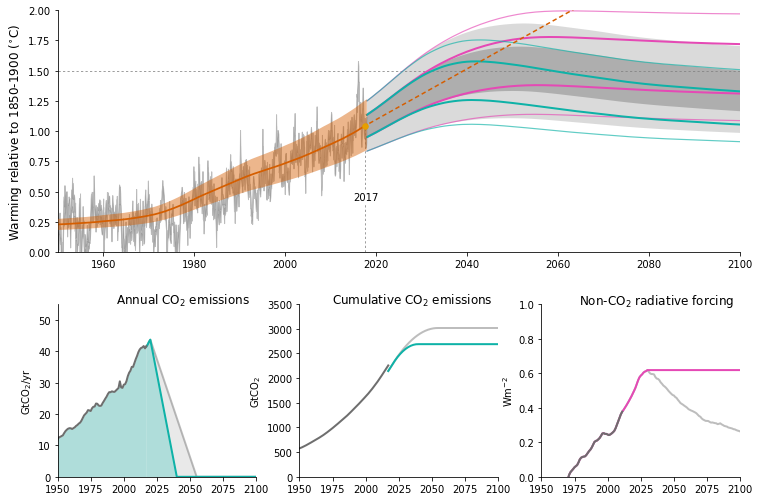

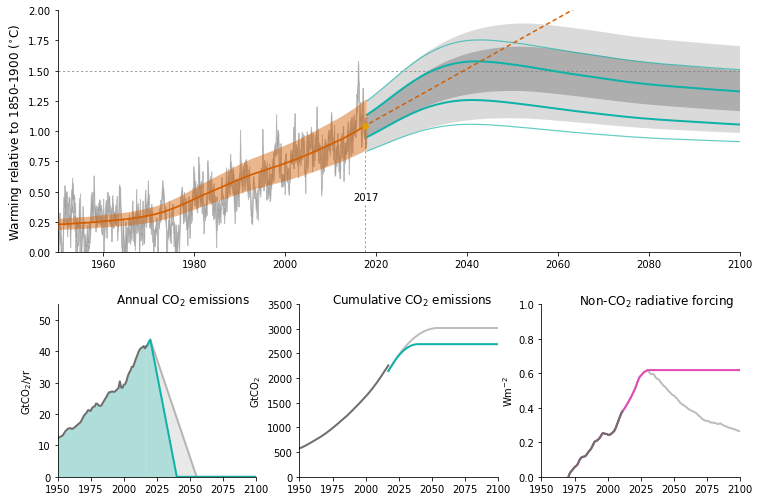

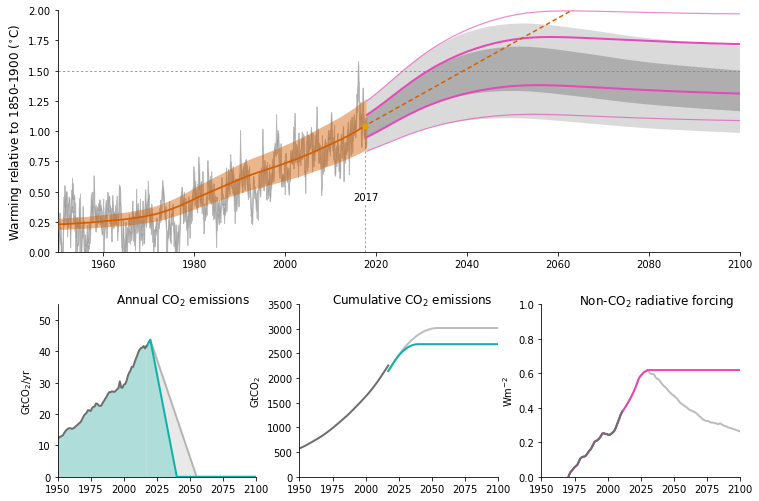

In [28]:
fig_all = figures_plot('all')
fig_co2_change = figures_plot('co2_change')
fig_rad_forc_change = figures_plot('rad_forc_change')

fig_all.savefig('./examplefigs/stuart_design/SPM_fig_all.pdf', dpi = 300)
fig_co2_change.savefig('./examplefigs/stuart_design/SPM_fig_co2_change.pdf', dpi = 300)
fig_rad_forc_change.savefig('./examplefigs/stuart_design/SPM_fig_rad_forc_change.pdf', dpi = 300)

plt.show()

In [65]:
line_1 = np.arange(100,0,-1) + np.random.rand(100)*10 + np.sin(x_vals/10. + 1.2)*20.
line_2 = line_1[0]*np.ones(100)

x_vals = np.arange(0,100)

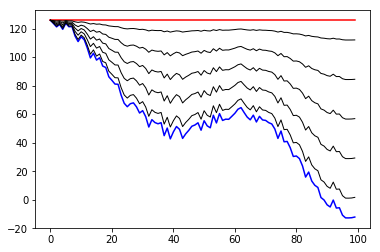

In [75]:
plt.plot(x_vals, line_1, linestyle = '-', color = 'blue') 
plt.plot(x_vals, line_2, linestyle = '-', color = 'red') 

for i in range(10,100,20):
    frac_merge = i/100.
    line_to_draw = line_1*(1-frac_merge) + line_2*frac_merge
    
    plt.plot(x_vals, line_to_draw, linestyle = '-', color = 'black', linewidth = 1.)
    
plt.show()